# Install, load the libraries

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 7.2MB/s 
     |████████████████████████████████| 3.3MB 51.9MB/s 
     |████████████████████████████████| 901kB 53.5MB/s 


In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Load, merge, clean the data

In [ ]:
# load the csv files
stock_des = pd.read_csv('stock_des.csv')
ta = pd.read_csv('ta.csv')
rev = pd.read_csv('rev.csv')

In [ ]:
# clean up the column names 
ta.rename(columns={'Unnamed: 0': 'ticker'}, inplace=True)
rev.rename(columns={'Unnamed: 0': 'ticker'}, inplace=True)

In [ ]:
# merge the dataframes into one
df = pd.merge(ta, rev, on='ticker')
df = pd.merge(df, stock_des, on='ticker')

In [ ]:
# remove the observations with ta and rev less than 10000 
print(df.shape)
df = df[(df['Total Assets'] >= 10000) & (df['Total Revenue'] >= 10000)]
print(df.shape)

(2830, 4)
(2719, 4)


count     2719.000000
mean        22.795845
std        386.905317
min          0.134677
25%          1.242993
50%          2.239040
75%          7.051726
max      18819.875000
Name: ar_ratio, dtype: float64


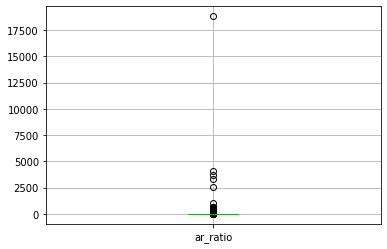

In [ ]:
# create the assets to revenue ratio 
df['ar_ratio'] = df['Total Assets']/df['Total Revenue']
print(df['ar_ratio'].describe())
df.boxplot(column='ar_ratio');

We have 6 outliers with the ratio of 1000+. Let's remove them. 

In [ ]:
df = df[df['ar_ratio']<1000]
print(df.shape)

(2713, 5)


Due to Colab's RAM limitations, limit the description size. We allow 350 characters, which is approximately 50 words and 3+ sentences. In case if you still face RAM issues try terminating other Colab notebooks (Runtime > Manage sessions) or reducing the characters to 300. 

In [ ]:
df['description'] = df['description'].str.slice(0,350)

Create a binary variable that is 1 if the assets to revenue ratio is above its median and 0 otherwise. 

This is the **dependent variable** (label) that we'll try to predict. 

In [ ]:
df['HIGH_ARR'] = (df['ar_ratio'].gt(df['ar_ratio'].median())).astype(int)

In [ ]:
df.sample(5)

,ticker,Total Assets,Total Revenue,description,ar_ratio,HIGH_ARR
1295,IIPR,1.768081e+09,1.168960e+08,"Innovative Industrial Properties, Inc. is a se...",15.125248,1
1098,GLW,3.077500e+10,1.130300e+10,Corning Incorporated engages in display techno...,2.722728,1
27,ACCO,3.048700e+09,1.655200e+09,"ACCO Brands Corporation designs, manufactures,...",1.841892,0
457,CASY,3.943892e+09,8.112296e+09,"Casey's General Stores, Inc., together with it...",0.486162,0
1321,INSP,2.811890e+08,1.153810e+08,"Inspire Medical Systems, Inc., a medical techn...",2.437048,1


# Preparing the predictor and DistilBERT model

**Note**. Please enable GPU in Edit > Notebook settings > Hardware accelerator. 

Load a pre-trained BERT model.

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tokenize the textual data for DistilBERT. 

In [ ]:
tokenized = df['description'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Pad all lists of tokenized values to the same size. 

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

(2713, 109)

Create attention mask variable for BERT to ignore (mask) the padding when it's processing its input.

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2713, 109)

# DistilBERT model

We run the pretrained DistilBERT model on the prepared predictor and keep the result in `last_hidden_states` variable. 

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

# Logistic regression model 



Keep the first layer of the hidden states and assign the outcome variable to `labels`. 

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels = df['HIGH_ARR']

Split the data in train and test subsets, train the Logistic Regression on train set and evaluate its accuracy on the test set. 

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(train_features, train_labels)
print(lr_clf.score(test_features, test_labels))

0.8114874815905744


Check if this approach works better than a random guess (0.8 > 0.5). 

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.507 (+/- 0.04)


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


The accuracy of a random guess is 0.5, which is much less than our model accuracy.

##Confusion Matrix

Text(0.5, 257.44, 'Predicted label')

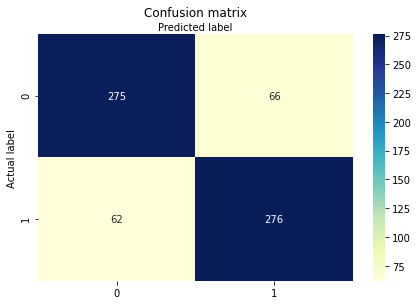

In [ ]:
from sklearn import metrics
y_pred = lr_clf.predict(test_features)
cm = metrics.confusion_matrix(test_labels, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

I used the sklearn package metrics to generate the confusion matrix and then used the seaborn heatmap to plot the confusion matrix. From the above confusion matrix plot, we can see that for most of the time the logistic regression model can predict very accurately. Out of 679 companies, it correctly predicts 276 companies as assets intensive companies and 275 companies as low assets companies. Only 66 companies with low assets are wrongly classified as assets intensive comanies, and 62 companies which are assets intensive are wrongly classified as low assets companies.

#R&D Intensity Prediction 

##Load, merge and clean the data

In [ ]:
rev_xrd = pd.read_csv('assign1.csv')
rev_xrd.rename(columns={'tic': 'ticker'}, inplace=True)
df1 = pd.merge(rev_xrd, stock_des, on='ticker')

In [ ]:
df1.shape

(2773, 4)

In [ ]:
#drop rows where sales are equal to 0
df1 = df1[df1['sale'] != 0]
df1.shape

(2678, 4)

In [ ]:
#inspect null values
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2678 entries, 0 to 2772
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ticker       2678 non-null   object 
 1   sale         2678 non-null   float64
 2   xrd          1492 non-null   float64
 3   description  2678 non-null   object 
dtypes: float64(2), object(2)
memory usage: 104.6+ KB


In [ ]:
#encode null as 0
df1['xrd'] = df1['xrd'].fillna(0)
df1.isnull().sum()

ticker         0
sale           0
xrd            0
description    0
dtype: int64

count    2678.000000
mean        3.804540
std        90.597764
min         0.000000
25%         0.000000
50%         0.000000
75%         0.064127
max      4299.125000
Name: RD_Intensity, dtype: float64


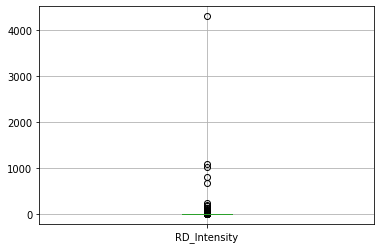

In [ ]:
df1['RD_Intensity'] = df1['xrd']/df1['sale']
print(df1['RD_Intensity'].describe())
df1.boxplot(column = 'RD_Intensity')

In [ ]:
df1['description'] = df1['description'].str.slice(0,350)

In [ ]:
df1['HIGH_INNOVATION'] = (df1['RD_Intensity'].gt(df1['RD_Intensity'].median())).astype(int)
df1.shape

(2678, 6)

In [ ]:
df1[df1['HIGH_INNOVATION'] == 1].shape

(1133, 6)

From above, we can tell that the number of companies which are classified as high_innovation and the number of those which are not classified as high_innovation are almost equivalent. This is a good sign for the modelling. 

##DistilBERT model

Since we loaded the pre-trained BERT model before, now we tokenize the description data for DistilBERT model

In [ ]:
tokenized1 = df1['description'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Pad all lists of tokenized values to the same size.

In [ ]:
max_len = 0
for i in tokenized1.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized1.values])

In [ ]:
np.array(padded).shape

(2678, 109)

Create attention mask variable for BERT to ignore (mask) the padding when it's processing its input.

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2678, 109)

Run the pretrained DistilBERT model on the prepared predictor and keep the result in `last_hidden_states` variable. 

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

##Logistic regression model

Keep the first layer of the hidden states and assign the outcome variable to `labels`. 

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels = df1['HIGH_INNOVATION']

Split the data in train and test subsets, train the Logistic Regression on train set and evaluate its accuracy on the test set. 

In [ ]:
train_features1, test_features1, train_labels1, test_labels1 = train_test_split(features, labels)
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(train_features1, train_labels1)
print(lr_clf.score(test_features1, test_labels1))

0.8850746268656716


The accuracy rate of the model is 0.89!

Check if this approach works better than a random guess (0.89 > 0.52)

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features1, train_labels1)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.517 (+/- 0.03)


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


The accuracy of a random guess is 0.5, which is much less than our model accuracy. 

##Confusion Matrix

Import the sklearn package metrics to generate the confusion matrix and then use the seaborn heatmap to plot the following confusion matrix.

Text(0.5, 257.44, 'Predicted label')

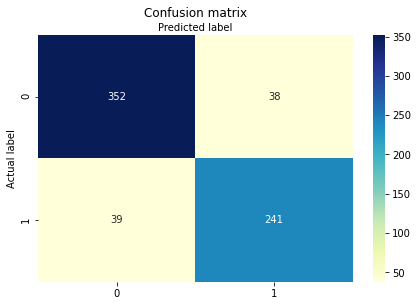

In [ ]:
y_pred1 = lr_clf.predict(test_features1)
cm = metrics.confusion_matrix(test_labels1, y_pred1)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

From the above confusion matrix plot, we can see that for most of the time the logistic regression model can predict very accurately. Out of 670 companies, it correctly predicts 241 companies as highly innovative companies and 352 companies as less innovative companies. Only 38 companies with low innovation are wrongly classified as highly innovative comanies, and 39 companies which are highly innovative are wrongly classified as companies with low innovation.

#Correlation between predicted value of HIGH_ARR and HIGH_INNOVATION

####Approach: put back the predicted values and compute the correlations from the merged table

Prepare HIGH_ARR table to be merged 

In [ ]:
t = test_labels.to_frame()
t['y_pred'] = y_pred

In [ ]:
df2 = pd.merge(df, t, left_index=True, right_index=True)
df2

,ticker,Total Assets,Total Revenue,description,ar_ratio,HIGH_ARR_x,HIGH_ARR_y,y_pred
3,AAL,6.200800e+10,1.733700e+10,"American Airlines Group Inc., through its subs...",3.576628,1,1,1
10,AAWW,6.029188e+09,3.211116e+09,"Atlas Air Worldwide Holdings, Inc., through it...",1.877599,0,0,0
14,ABEO,1.511980e+08,1.000000e+07,"Abeona Therapeutics Inc., a clinical-stage bio...",15.119800,1,1,1
23,ACAD,7.826160e+08,4.417550e+08,"ACADIA Pharmaceuticals Inc., a biopharmaceutic...",1.771606,0,0,1
26,ACCD,7.324800e+07,1.325070e+08,"Accolade, Inc. develops and provides technolog...",0.552786,0,0,1
...,...,...,...,...,...,...,...,...
2797,XONE,1.072890e+08,5.925300e+07,"The ExOne Company develops, manufactures, and ...",1.810693,0,0,0
2800,XPO,1.616900e+10,1.625200e+10,"XPO Logistics, Inc. provides supply chain solu...",0.994893,0,0,0
2805,YELP,1.154947e+09,8.729330e+08,Yelp Inc. operates a platform that connects co...,1.323065,0,0,0
2807,YEXT,5.959890e+08,3.546610e+08,"Yext, Inc. organizes business facts to provide...",1.680447,0,0,1


Prepare HIGH_INNOVATION table to be merged

In [ ]:
t1 = test_labels1.to_frame()
t1['y_pred1'] = y_pred1

In [ ]:
df3 = pd.merge(df1, t1, left_index=True, right_index=True)
df3

,ticker,sale,xrd,description,RD_Intensity,HIGH_INNOVATION_x,HIGH_INNOVATION_y,y_pred1
0,AAL,17337.000,0.0,"American Airlines Group Inc., through its subs...",0.000000,0,0,0
6,APD,8856.300,83.9,"Air Products and Chemicals, Inc. provides atmo...",0.009473,1,1,1
7,ALK,3566.000,0.0,"Alaska Air Group, Inc., through its subsidiari...",0.000000,0,0,0
9,MATX,2383.300,0.0,"Matson, Inc., together with its subsidiaries, ...",0.000000,0,0,0
13,HON,32637.000,1334.0,Honeywell International Inc. operates as a div...,0.040874,1,1,1
...,...,...,...,...,...,...,...,...
2755,CATM,1093.999,0.0,Cardtronics plc provides automated consumer fi...,0.000000,0,0,0
2757,CNS,427.536,0.0,"Cohen &amp; Steers, Inc. is a publicly owned a...",0.000000,0,0,0
2766,GAN,35.159,0.0,GAN Limited operates as a business-to-business...,0.000000,0,0,1
2767,LPG,318.218,0.0,"Dorian LPG Ltd., together with its subsidiarie...",0.000000,0,0,0


Merge the two tables on the same ticker

In [ ]:
df4 = pd.merge(df2, df3, on='ticker')
df4.head()

,ticker,Total Assets,Total Revenue,description_x,ar_ratio,HIGH_ARR_x,HIGH_ARR_y,y_pred,sale,xrd,description_y,RD_Intensity,HIGH_INNOVATION_x,HIGH_INNOVATION_y,y_pred1
0,AAL,6.200800e+10,1.733700e+10,"American Airlines Group Inc., through its subs...",3.576628,1,1,1,17337.000,0.000,"American Airlines Group Inc., through its subs...",0.00000,0,0,0
1,ACCD,7.324800e+07,1.325070e+08,"Accolade, Inc. develops and provides technolog...",0.552786,0,0,1,170.358,0.000,"Accolade, Inc. develops and provides technolog...",0.00000,0,0,1
2,ADES,1.466710e+08,6.157700e+07,"Advanced Emissions Solutions, Inc., together w...",2.381912,1,1,1,61.577,1.000,"Advanced Emissions Solutions, Inc., together w...",0.01624,1,1,1
3,ADMA,2.076734e+08,4.221978e+07,"ADMA Biologics, Inc., a biopharmaceutical comp...",4.918865,1,1,0,42.220,5.907,"ADMA Biologics, Inc., a biopharmaceutical comp...",0.13991,1,1,1
4,AEE,3.203000e+10,5.540000e+09,"Ameren Corporation, together with its subsidia...",5.781588,1,1,1,5794.000,0.000,"Ameren Corporation, together with its subsidia...",0.00000,0,0,0


Calculate the correlation between the HIGH_ARR predicted values and HIGH_INNOVATION predicted values for same companies

In [ ]:
print(np.corrcoef(df4['y_pred'], df4['y_pred1']))

[[ 1.         -0.25785531]
 [-0.25785531  1.        ]]


We can see that the predicted values of HIGH_ARR and HIGH_INNOVATION is slightly correlated with each other in a negative way (-0.26), which makes sense as companies which are assets intensive tend to be manufacturers and less innovative. A lot of innovative companies are less assets intensive.  